In [2]:
#패키지 불러오기
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

#MNIST 데이터 불러오기
train_data_raw= datasets.MNIST(root='./data', train=True, download=True)
test_data_raw= datasets.MNIST(root='./data', train=False, download=True)

ModuleNotFoundError: No module named 'torch'

Traindataset information: 
Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train

Testdataset information: 
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test

Trainimages shape: torch.Size([60000, 28, 28])
Testimages shape: torch.Size([10000, 28, 28])


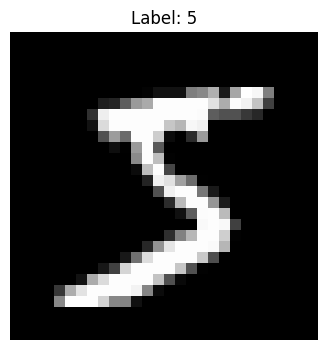

In [ ]:
#데이터 정보 및 차원 확인
print(f"Traindataset information: \n{train_data_raw}\n")
print(f"Testdataset information: \n{test_data_raw}\n")
print(f"Trainimages shape: {train_data_raw.data.shape}")
print(f"Testimages shape: {test_data_raw.data.shape}")

#데이터 예시 시각화
image, label = train_data_raw[0]
plt.figure(figsize=(4, 4))
plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [ ]:
# Batch설정
BATCH_SIZE = 64

# 전처리적용
# 1. ToTensor() : 이미지를 PyTorch 텐서로 변환(0-255 -> 0.0-1.0)
# 2. Normalize() : 데이터정규화 (평균0.1307, 표준편차0.3081은 MNIST 데이터셋의 통계값)
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

# 전처리를 적용하여 데이터셋 다시로드
train_dataset= datasets.MNIST(root='./data', train=True, download=True,transform=transform)
test_dataset= datasets.MNIST(root='./data', train=False, download=True,transform=transform)


In [ ]:
# Train/Test Split
train_loader= DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader= DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,shuffle=False)

# Batch 개수확인
print(f"Trainbatch : {len(train_loader)}")
print(f"Testbatch : {len(test_loader)}")

Trainbatch : 938
Testbatch : 157


In [ ]:
# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# MLP 모델 클래스 정의
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        self.layers = nn.Sequential(
            nn.Flatten(),  # 28x28 2D 이미지를 784 1D 벡터로 flatten
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)  # 출력층 (0~9)
        )

    def forward(self, x):
        return self.layers(x)
    
# 모델호출및Loss function, Optimizer 정의
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print(model)


Device: cuda
MLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [ ]:
model.eval()  # 모델을 평가 모드로 설정
all_preds = []
all_labels = []
correct = 0
total = 0

with torch.no_grad():  # 평가 시에는 기울기 계산 비활성화
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        # 가장 높은 값을 갖는 인덱스를 예측값으로 선택
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Confusion matrix 작성을 위한 값 저장
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Test data accuracy: 6.64%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.06      0.30      0.10      1135
           2       0.09      0.01      0.01      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.08      0.31      0.13       892
           6       0.25      0.04      0.07       958
           7       0.01      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.07     10000
   macro avg       0.05      0.07      0.03     10000
weighted avg       0.05      0.07      0.03     10000



c:\Users\user\anaconda3\envs\shsh\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\anaconda3\envs\shsh\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\anaconda3\envs\shsh\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


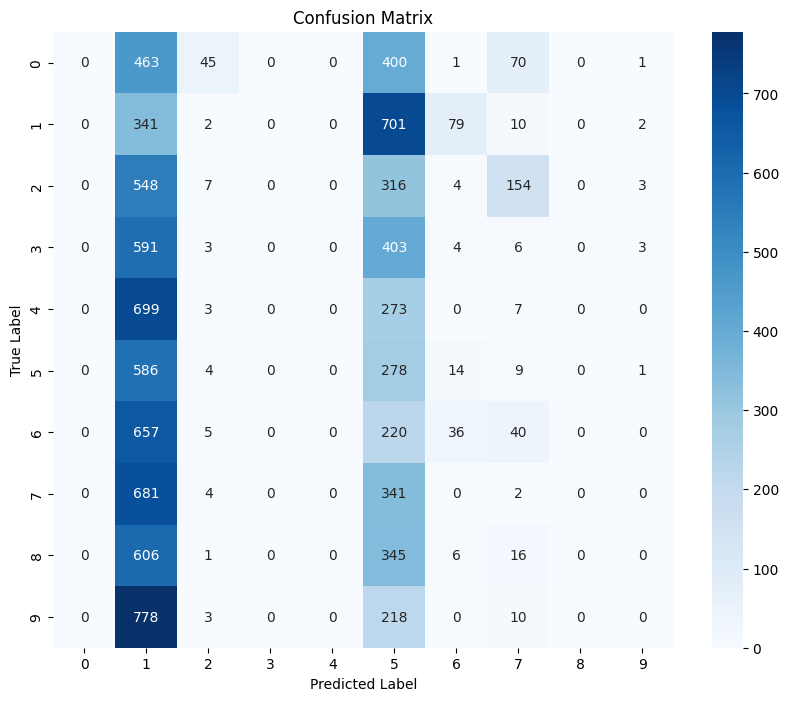

In [ ]:
# 평가지표 출력
accuracy = 100 * correct / total
print(f"Test data accuracy: {accuracy:.2f}%")
print(classification_report(all_labels, all_preds))

# Confusion Matrix (혼동행렬) 시각화
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
